In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.10',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Additional devlib modules required for this experiment
    "modules" : ['hwmon'],
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

04:35:52  INFO    :         Target - Using base path: /home/derkling/Code/schedtest
04:35:52  INFO    : %14s - Loading custom (inline) target configuration
04:35:52  INFO    :         Target - Connecting linux target with: {'username': 'root', 'host': '192.168.0.10', 'password': ''}
04:35:52  DEBUG   : Logging in root@192.168.0.10
04:35:54  DEBUG   : echo $PATH
04:35:54  DEBUG   : ls -1 /usr/local/bin
04:35:54  DEBUG   : cat /proc/cpuinfo
04:35:55  DEBUG   : id
04:35:55  DEBUG   : sudo -- sh -c 'dmidecode -s system-version'
04:35:56  DEBUG   : uname -m
04:35:56  DEBUG   : if [ -e '/sys/devices/system/cpu/cpufreq' ]; then echo 1; else echo 0; fi
04:35:57  DEBUG   : if [ -e '/sys/devices/system/cpu/cpu0/cpufreq' ]; then echo 1; else echo 0; fi
04:35:57  DEBUG   : if [ -e '/sys/class/hwmon' ]; then echo 1; else echo 0; fi
04:35:57  DEBUG   : ls -1 /sys/class/hwmon
04:35:58  DEBUG   : if [ -e '/sys/class/hwmon/hwmon0/name' ]; then echo 1; else echo 0; fi
04:35:58  DEBUG   : sudo -- sh -c '

# Workload configuration

In [5]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        # 3. PERIODIC task with
        'task_p20': RTA.periodic(
            period_ms=100,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=5,          # duration    
            cpus='0'               # pinned on CPU0
        ),
        
        # 4. RAMP task (i.e. increasing load) with
        'task_r20_5-60': RTA.ramp(
            start_pct=5,           # intial load
            end_pct=65,            # end load
            delta_pct=20,          # load % increase...
            time_s=1,              # ... every 1[s]
            # pinned on last CPU of the target
            cpus=str(len(target.core_names)-1)
        ),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

04:36:36  INFO    : Setup new workload simple
04:36:36  INFO    : Workload duration defined by longest task
04:36:36  INFO    : Default policy: SCHED_OTHER
04:36:36  INFO    : ------------------------
04:36:36  INFO    : task [task_p20], sched: using default policy
04:36:36  INFO    :  | loops count: 1
04:36:36  INFO    :  | CPUs affinity: 0
04:36:36  INFO    :  + phase_000001: duration 5.000000 [s] (50 loops)
04:36:36  INFO    :  |  period   100000 [us], duty_cycle  20 %
04:36:36  INFO    :  |  run_time  20000 [us], sleep_time  80000 [us]
04:36:36  INFO    : ------------------------
04:36:36  INFO    : task [task_r20_5-60], sched: using default policy
04:36:36  INFO    :  | loops count: 1
04:36:36  INFO    :  | CPUs affinity: 5
04:36:36  INFO    :  + phase_000001: duration 1.000000 [s] (10 loops)
04:36:36  INFO    :  |  period   100000 [us], duty_cycle   5 %
04:36:36  INFO    :  |  run_time   5000 [us], sleep_time  95000 [us]
04:36:36  INFO    :  + phase_000002: duration 1.000000 [s] 

# Workload execution

In [6]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir)

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

04:36:36  INFO    : #### Setup FTrace
04:36:36  DEBUG   : sudo -- sh -c 'echo 10240 > '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
04:36:36  DEBUG   : sudo -- sh -c 'cat '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
04:36:37  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd reset'
04:36:39  DEBUG   : sudo -- sh -c 'echo TRACE_MARKER_START > '\''/sys/kernel/debug/tracing/trace_marker'\'''
04:36:40  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd start -e sched_switch -e cpu_frequency'
04:36:42  INFO    : #### Start energy sampling
04:36:42  DEBUG   : sudo -- sh -c 'cat '\''/sys/class/hwmon/hwmon13/energy1_input'\'''
04:36:43  DEBUG   : sudo -- sh -c 'cat '\''/sys/class/hwmon/hwmon14/energy1_input'\'''
04:36:43  INFO    : #### Start RTApp execution
04:36:43  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/simple_00.json
04:36:43  DEBUG   : /root/devlib-target/bin/rt-app /root/devlib-target/simple_00.json
04:36:49  DEBUG   : /us

# Collected results

In [7]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

04:36:54  INFO    : Content of the output folder /home/derkling/Code/schedtest/results/20151113_163636


total 3300
drwxrwxr-x  2 derkling derkling    4096 Nov 13 16:36 .
drwxrwxr-x 38 derkling derkling    4096 Nov 13 16:36 ..
-rw-rw-r--  1 derkling derkling      52 Nov 13 16:36 energy.json
-rw-rw-r--  1 derkling derkling     436 Nov 13 16:36 output.log
-rw-rw-r--  1 derkling derkling     649 Nov 13 16:36 platform.json
-rw-r--r--  1 derkling derkling    6360 Nov 13 16:36 rt-app-task_p20-0.log
-rw-r--r--  1 derkling derkling    5120 Nov 13 16:36 rt-app-task_r20_5-60-1.log
-rw-r--r--  1 derkling derkling    1828 Nov 13 16:36 simple_00.json
-rw-r--r--  1 derkling derkling 3338240 Nov 13 16:36 trace.dat


In [8]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

04:36:54  INFO    : Generated RTApp JSON file:


{
    "global": {
        "calibration": 138, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/root/devlib-target"
    }, 
    "tasks": {
        "task_p20": {
            "cpus": [
                0
            ], 
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 50, 
                    "run": 20000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_p20"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }, 
        "task_r20_5-60": {
            "cpus": [
                5
            ], 
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 10, 
                    "run": 5000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_r20_5-60"
                    }
          

In [9]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_file)
print json.dumps(nrg, indent=4, sort_keys=True)

04:36:54  INFO    : Energy: /home/derkling/Code/schedtest/results/20151113_163636/energy.json


{
    "LITTLE": "9.895538", 
    "big": "2.266392"
}


In [10]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

04:36:54  INFO    : Platform description: /home/derkling/Code/schedtest/results/20151113_163636/platform.json


{
    "clusters": {
        "big": [
            1, 
            2
        ], 
        "little": [
            0, 
            3, 
            4, 
            5
        ]
    }, 
    "cpus_count": 6, 
    "freqs": {
        "big": [
            450000, 
            625000, 
            800000, 
            950000, 
            1100000
        ], 
        "little": [
            450000, 
            575000, 
            700000, 
            775000, 
            850000
        ]
    }, 
    "topology": [
        [
            0, 
            3, 
            4, 
            5
        ], 
        [
            1, 
            2
        ]
    ]
}


# Trace inspection

In [11]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# RTApp task performance plots

04:36:55  INFO    : Found rt-app logfile for task [task_r20_5-60]
04:36:55  INFO    : Found rt-app logfile for task [task_p20]
04:36:55  INFO    : Loading dataframe for task [task_p20]...
04:36:55  INFO    : Loading dataframe for task [task_r20_5-60]...
04:36:55  INFO    : PerfIndex, Task [task_p20] avg: 0.59, std: 0.01
04:36:55  INFO    : PerfIndex, Task [task_r20_5-60] avg: -4.14, std: 7.68


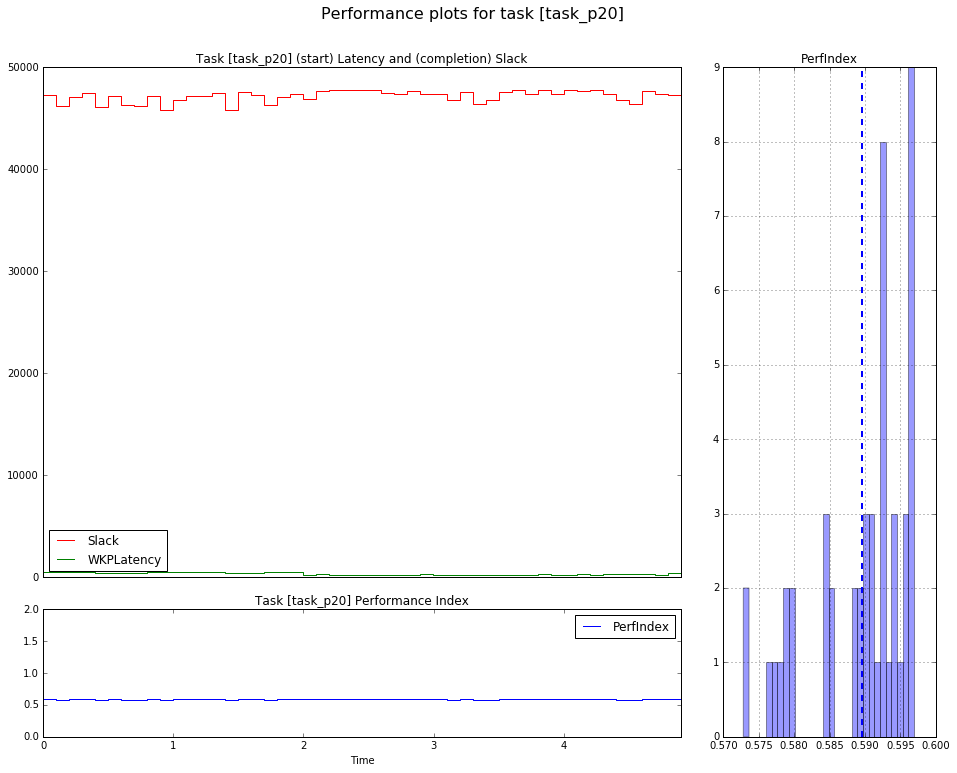

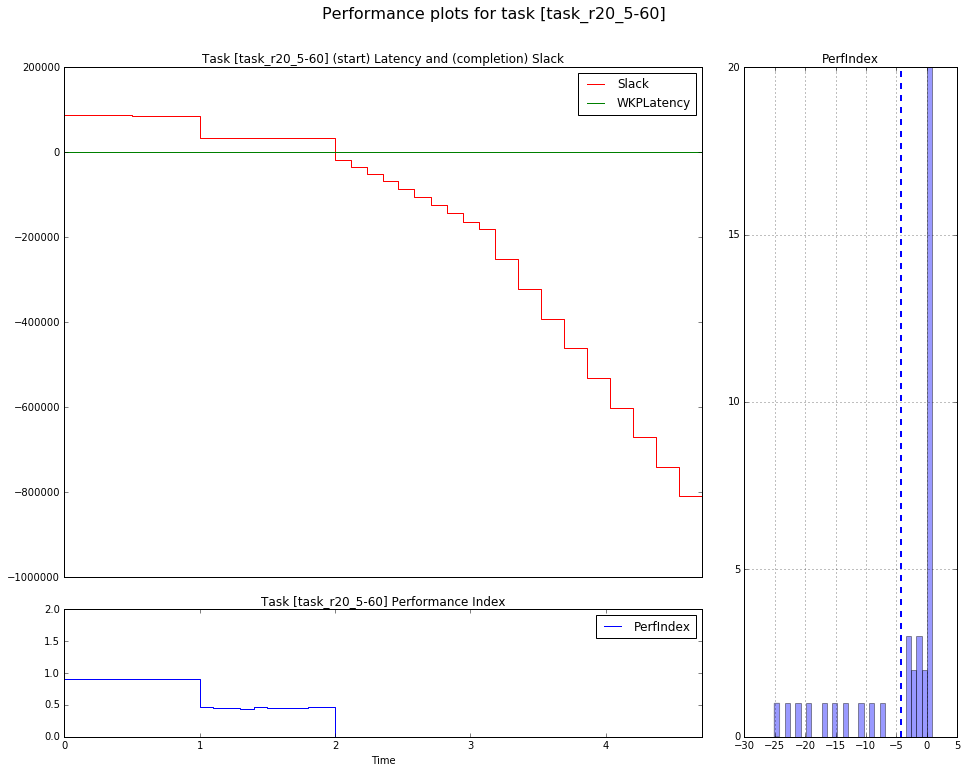

In [12]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))